In [1]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

# Extend nn.Module, and implement/overwrite some methods.
# Namely, write a constructor and a .forward() method.
class Model(nn.Module):
    
    # Can take any args you want
    # This defines the structure and attributes of the network.
    # The actual control flow comes later.
    def __init__(self):
        super(Model, self).__init__()
        
        self.n_inputs = 784
        self.hidden_dim = 50
        self.n_middle_layers = 10
        self.output_dim = 10
        self.first_layer = nn.Linear(self.n_inputs, self.hidden_dim)
        self.middle_layers = [
            nn.Linear(self.hidden_dim, self.hidden_dim)
            for _ in range(self.n_middle_layers)
        ]
        
        # If your layers are not stored directly as an attribute you
        # MUST add them as submodules or pass the optimiser their
        # parameters directly.
        for layer_index, layer in enumerate(self.middle_layers):
            self.add_module('middle_{}'.format(layer_index), layer)
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)
        
        norm_dim = -1
        self.logprobs = nn.LogSoftmax(dim=norm_dim)
    
    # This takes your input to your output.
    def forward(self, x, verbose=False):
        import random
        
        # This is like reshape without copy.
        # -1 means compute the remaining dims automatically.
        if verbose:
            print(x.size())
        x = x.view(-1, self.n_inputs)
        if verbose:
            print(x.size())
        
        # The functional API is used typically for 'layers' which
        # don't have parameters. e.g. things like ReLU.
        first_act = F.relu(self.first_layer(x))
        
        representation = first_act
        
        # Because torch is dynamic, we can determine the
        # order of computation at runtime.
        # Here we'll randomly propogate through the first 1 or more
        # 'middle' layers.
        layers_this_run = self.middle_layers[
            :random.randint(1, self.n_middle_layers)
        ]
        for index, layer in enumerate(layers_this_run):
            if verbose:
                print('Fprop with middle layer {}'.format(index))
            representation = F.relu(layer(representation))
            
        return self.logprobs(self.output_layer(representation))

# There is a newer way of doing this.
# But I have not got used to it yet.
use_cuda = torch.cuda.is_available()

model = Model()
if use_cuda:
    model = model.cuda()

In [2]:
# Numpy-like methods for array creation.
dummy_pattern = torch.zeros(784)

# arithmetic operations as you'd expect
dummy_pattern = dummy_pattern + torch.ones(784)

# cast numpy to torch tensor
import numpy as np
numpy_vector = np.random.randn(784)
print(numpy_vector[:5])

try:
    dummy_pattern = dummy_pattern - torch.tensor(numpy_vector)
except RuntimeError as e:
    print('Types matter! torch.float by default usually.')
    print(e)
finally:
    dummy_pattern = dummy_pattern + torch.tensor(numpy_vector, dtype=torch.float)
print(dummy_pattern[:5])

if use_cuda:
    dummy_pattern = dummy_pattern.cuda()

[ 0.00684534 -0.85643491  0.612418   -0.60902663  0.28375679]
Types matter! torch.float by default usually.
Expected object of type torch.FloatTensor but found type torch.DoubleTensor for argument #3 'other'
tensor([ 1.0068,  0.1436,  1.6124,  0.3910,  1.2838])


In [3]:
for _ in range(5):
    dummy_out = model(dummy_pattern, verbose=True)
    print()
print(dummy_out)

torch.Size([784])
torch.Size([1, 784])
Fprop with middle layer 0

torch.Size([784])
torch.Size([1, 784])
Fprop with middle layer 0
Fprop with middle layer 1
Fprop with middle layer 2
Fprop with middle layer 3
Fprop with middle layer 4

torch.Size([784])
torch.Size([1, 784])
Fprop with middle layer 0
Fprop with middle layer 1
Fprop with middle layer 2
Fprop with middle layer 3
Fprop with middle layer 4
Fprop with middle layer 5

torch.Size([784])
torch.Size([1, 784])
Fprop with middle layer 0
Fprop with middle layer 1
Fprop with middle layer 2
Fprop with middle layer 3

torch.Size([784])
torch.Size([1, 784])
Fprop with middle layer 0
Fprop with middle layer 1
Fprop with middle layer 2

tensor([[-2.4169, -2.2400, -2.1977, -2.2712, -2.3733, -2.1947, -2.4059,
         -2.3388, -2.2289, -2.3941]])


In [4]:
# Torchvision has a bunch of nice handlers for loader and transforming data.
# But you don't have to use them, and can write your own.
from torchvision import datasets, transforms
import os

# I don't fully understand this, but it can improve performance
# to mess with the settings... Should look it up really.
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

data_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
data_path = os.path.join(os.getcwd(), 'data')
if not os.path.isdir(data_path):
    os.makedirs(data_path)
loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        data_path, train=True, download=True,
        transform=data_norm
    ),
    batch_size=60, shuffle=True, **kwargs
)

In [5]:
# Your model has already inherited .parameters from nn.Module
# This gets all the adaptive parameters of any attributes of the model,
# or modules which have been added manually. Make sure your model is
# exposing everything with adaptive parameters! (Unless you're sure)
optimiser = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [6]:
losses = []
for epoch in range(3):
    for index, (data, target) in enumerate(loader, 1):
        # Again there's a newer way to do this...
        # But this still works.
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # This is important! By default, gradients ACCUMULATE in buffers.
        # This can be useful in many situations, but is counter-intuitive to
        # start with. .zero_grad() zeroes these buffers out.
        optimiser.zero_grad()

        output = model(data, verbose=False)

        loss = F.nll_loss(output, target)

        # Compute derivatives of loss
        loss.backward()

        # Update model parameters using what's in the gradient buffers
        optimiser.step()

        # Actually compute the loss value
        loss_value = loss.item()
        losses.append(loss_value)

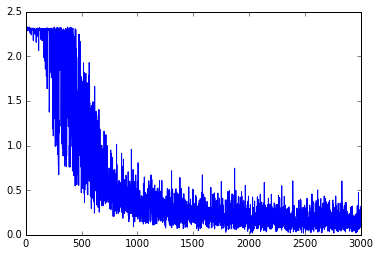

In [7]:
from matplotlib import pyplot as plt
% matplotlib inline
plt.plot(losses)